In this notebook we want to make a xgboost classification of out 56000 pull request which 10k are non-merged and 46k are merged. we want to do two stage classification and prediction, first stage is for non merged and merged, and then we want to predict and classifiy each category after that


In [90]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import ast
import numpy as np



/var/folders/v7/m50ww3p142130jtt2scggl3r0000gq/T/ipykernel_89332/552830788.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [15]:
df = pd.read_csv('/Users/amirrshams/Library/CloudStorage/OneDrive-UniversityofWaterloo/Thesis/Dataset/Dataset/sampled_dataset.csv')
df_nonmerged = pd.read_csv('/Users/amirrshams/Library/CloudStorage/OneDrive-UniversityofWaterloo/Thesis/Dataset/Dataset/Non_Merged/Sample/Sample_10000_new_manual.csv')

In [4]:
df.head()

,Unnamed: 0.1,Unnamed: 0,repo_id,status,pr_id,pullreq_id,api_url,url,pr_url,pr_api_url,author_id,author_desc_body,closer_id,comments_counts,comments,commit_counts,code_changes_counts,created_at,closed_at,author_country,closer_country,author_continent,same_country,author_eth,closer_eth,same_eth,prs_white,prs_api,prs_black,prs_hispanic,pri_white,pri_black,pri_api,pri_hispanic,prs_eth_8,prs_eth_7,prs_eth_9,prs_eth_diff,prs_eth_diff_2,prs_pri_same_nationality,prs_experience,prs_succ_rate,prs_popularity,prs_watched_repo,prs_followed_pri,prs_tenure_mnth,prs_main_team_member,repo_pr_tenure_mnth,repo_pr_popularity,repo_pr_team_size,perc_external_contribs,pr_opened_at,pr_files_changed,pr_lines_changed,intra_branch
0,1,2250,6,not-merged,2697422,4651,https://api.github.com/repos/cocos2d/cocos2d-x,https://github.com/cocos2d/cocos2d-x,https://github.com/cocos2d/cocos2d-x/pull/4651,https://api.github.com/repos/cocos2d/cocos2d-x...,CocosRobot,\N,NaN,-1.623582,[],-0.500975,1,2013-12-25 04:04:41,2013-12-25 05:41:54,\N,\N,\N,0,Unknown,API,0,0.889200,0.008001,0.088110,0.014689,0.059421,0.003402,0.933594,0.001673,Unknown,White,Unknown,White,White,0,1.915057,1.150350,-0.444593,0,0,0.077583,0,0.224940,1.028133,0.992756,-0.699726,1387940681,-1.047192,-1.251865,0
1,2,5916,6,not-merged,7456135,11761,https://api.github.com/repos/cocos2d/cocos2d-x,https://github.com/cocos2d/cocos2d-x,https://github.com/cocos2d/cocos2d-x/pull/11761,https://api.github.com/repos/cocos2d/cocos2d-x...,CocosRobot,\N,NaN,-1.623582,[],-0.500975,9,2015-05-08 09:07:16,2015-05-11 01:53:15,\N,china,\N,0,Unknown,Unknown,0,0.889200,0.008001,0.088110,0.014689,0.569895,0.032570,0.367695,0.028239,Unknown,White,Unknown,White,White,0,2.676846,0.764089,-0.161012,0,0,0.488885,0,0.608178,1.292924,1.375811,-0.232106,1431068836,-1.047192,-1.251865,0
2,3,17935,183,not-merged,645270,2808,https://api.github.com/repos/zendframework/zen...,https://github.com/zendframework/zendframework,https://github.com/zendframework/zendframework...,https://api.github.com/repos/zendframework/zen...,blanchonvincent,Usage with static instead of self\n,NaN,-1.623582,[],-0.500975,1,2012-10-19 19:34:23,2012-10-30 19:46:43,france,united states,Europe,0,White,White,1,0.982306,0.003467,0.010741,0.002705,0.930962,0.031869,0.009878,0.025256,White,White,White,White,White,0,0.995788,1.083482,0.968358,1,0,-1.253013,0,-0.069841,1.172173,0.886383,0.179764,1350668063,-1.047192,-1.251865,0
3,4,19620,183,not-merged,2203867,5219,https://api.github.com/repos/zendframework/zen...,https://github.com/zendframework/zendframework,https://github.com/zendframework/zendframework...,https://api.github.com/repos/zendframework/zen...,samsonasik,\N,NaN,0.182242,"['Woah, ancient links spotting :O\n', '@Ocrami...",-0.500975,1,2013-10-03 19:34:04,2013-10-03 19:48:05,indonesia,spain,Asia,0,API,White,0,0.024666,0.975110,0.000109,0.000099,0.996368,0.002142,0.000852,0.000634,API,API,API,API,API,0,1.759672,0.880055,1.906032,1,1,0.279995,0,0.280881,1.227766,1.307105,0.144283,1380821644,-1.047192,-1.251865,0
4,5,27952,340,not-merged,23622497,6647,https://api.github.com/repos/netty/netty,https://github.com/netty/netty,https://github.com/netty/netty/pull/6647,https://api.github.com/repos/netty/netty/pulls...,fenik17,Motivation:\r\n\r\n1. The use of the `Internet...,NaN,-0.720670,['Cherry-picked into 4.1 (970d310ec9ae3d0581ad...,-0.500975,3,2017-04-19 18:56:34,2017-04-20 03:23:50,russia,germany,Asia,0,White,White,1,0.990941,0.000334,0.000025,0.008697,0.992539,0.000581,0.003632,0.002701,White,White,White,White,White,0,0.105514,-1.103914,-0.997446,1,1,-1.017751,0,1.009221,1.516362,1.220494,-0.886764,1492628194,-1.047192,-1.251865,0


# preprocessing
only keep the values that are important to us and are used in the model

In [16]:
#merge the two datasets and only add the manual analysis column
df = pd.concat([df, df_nonmerged['manual_analysis']], axis=1)

In [17]:
#drop all columns except for commit_counts + prs_experience + prs_succ_rate + prs_popularity + prs_followed_pri + prs_watched_repo + prs_tenure_mnth + prs_main_team_member + repo_pr_tenure_mnth + repo_pr_popularity + repo_pr_team_size + perc_external_contribs +intra_branch + pr_files_changed + pr_lines_changed + (1 | repo_id) + (1 | author_id)
df = df[['pr_id', 'commit_counts', 'prs_experience', 'prs_succ_rate', 'prs_popularity', 'prs_followed_pri', 'prs_watched_repo', 'prs_tenure_mnth', 'prs_main_team_member', 'repo_pr_tenure_mnth', 'repo_pr_popularity', 'repo_pr_team_size', 'perc_external_contribs', 'intra_branch', 'pr_files_changed', 'pr_lines_changed', 'repo_id','status', 'manual_analysis']]

In [18]:
#show rows with NaN values
df[df.isna().any(axis=1)]
#how many of the rows in perc_external_contrib are NaN 
df['perc_external_contribs'].isna().sum()
#show where perc_external_contribs and manual_analysis are NaN
df[df['perc_external_contribs'].isna() & df['manual_analysis'].isna()]

,pr_id,commit_counts,prs_experience,prs_succ_rate,prs_popularity,prs_followed_pri,prs_watched_repo,prs_tenure_mnth,prs_main_team_member,repo_pr_tenure_mnth,repo_pr_popularity,repo_pr_team_size,perc_external_contribs,intra_branch,pr_files_changed,pr_lines_changed,repo_id,status,manual_analysis
11811,83434,-0.540434,-1.532904,-1.714328,-1.135762,1,1,0.103728,0,-3.734906,-0.827321,-2.470590,NaN,0,-0.488071,-0.857099,4416,merged,NaN
13035,112871,-0.540434,-1.532904,-1.714328,-1.555667,0,1,-3.555457,0,-3.734906,-1.938174,-2.470590,NaN,0,-1.195553,-1.357043,6286,merged,NaN
14055,550093,-0.540434,-0.724022,0.790595,0.871954,0,0,-0.639497,0,-3.734906,-0.712193,-0.572532,NaN,1,-1.195553,-1.357043,8623,merged,NaN
14486,711063,1.554526,-1.532904,-1.714328,0.631808,1,0,0.043169,0,-2.543178,0.317436,-0.310316,NaN,0,0.219410,0.752076,9703,merged,NaN
14657,279617,-0.540434,-0.375655,0.726262,0.543858,0,1,-0.089816,0,-3.734906,-1.027982,-1.323155,NaN,0,-0.488071,-0.226240,10102,merged,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52719,150397,-0.540434,0.380274,0.775170,0.043060,0,1,-0.701892,0,-2.983010,-1.465002,-2.470590,NaN,0,-0.488071,-0.624638,287583,merged,NaN
52763,196520,-0.540434,-1.532904,-1.714328,-1.135762,0,1,-3.555457,0,0.121783,-1.234648,-2.470590,NaN,0,-0.488071,-0.357155,44939,merged,NaN
52764,1148556,-0.540434,-0.108968,0.881928,0.647964,0,0,0.132722,0,-1.791282,-0.414212,-2.470590,NaN,0,-0.488071,-0.067737,404631,merged,NaN
52814,1762565,-0.540434,-0.980756,-1.714328,-0.580678,0,0,0.160921,0,-1.624066,-1.676416,-2.470590,NaN,0,0.926891,-0.124695,2245795,merged,NaN


In [19]:
#make status column binary, non-merged = 1 and merged = 0
df['status'] = df['status'].replace('merged', 0)
df['status'] = df['status'].replace('not-merged', 1)

In [45]:
#remove the duplicate rows
df = df.drop_duplicates(subset=['pr_id'], keep='first')

In [46]:
#encode the manual_analysis column using one-hot encoding
label_encoder = LabelEncoder()
df['manual_analysis'] = label_encoder.fit_transform(df['manual_analysis'])
#show what is encoded to what

encoded_classes = label_encoder.classes_
encoded_values = label_encoder.transform(label_encoder.classes_)
class_to_number_mapping = dict(zip(encoded_classes, encoded_values))

# Displaying the mapping
print("Category to encoded number mapping:")
for category, num in class_to_number_mapping.items():
    print(f"{category}: {num}")




Category to encoded number mapping:
0: 0
1: 1
2: 2
3: 3
4: 4
5: 5
6: 6
7: 7
8: 8
9: 9
10: 10
11: 11
12: 12


In [61]:
df.count()

pr_id                     52778
commit_counts             52778
prs_experience            52778
prs_succ_rate             52778
prs_popularity            52778
prs_followed_pri          52778
prs_watched_repo          52778
prs_tenure_mnth           52778
prs_main_team_member      52778
repo_pr_tenure_mnth       52778
repo_pr_popularity        52778
repo_pr_team_size         52778
perc_external_contribs    52060
intra_branch              52778
pr_files_changed          52778
pr_lines_changed          52778
repo_id                   52778
status                    52778
manual_analysis           52778
Consistently_Correct      52778
dtype: int64

In [40]:
#in case of using smote
# imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent', etc.
# X_imputed = imputer.fit_transform(X)

# # Apply SMOTE
# smote = SMOTE()
# X_smote, y_smote = smote.fit_resample(X_imputed, y)



NameError: name 'y' is not defined

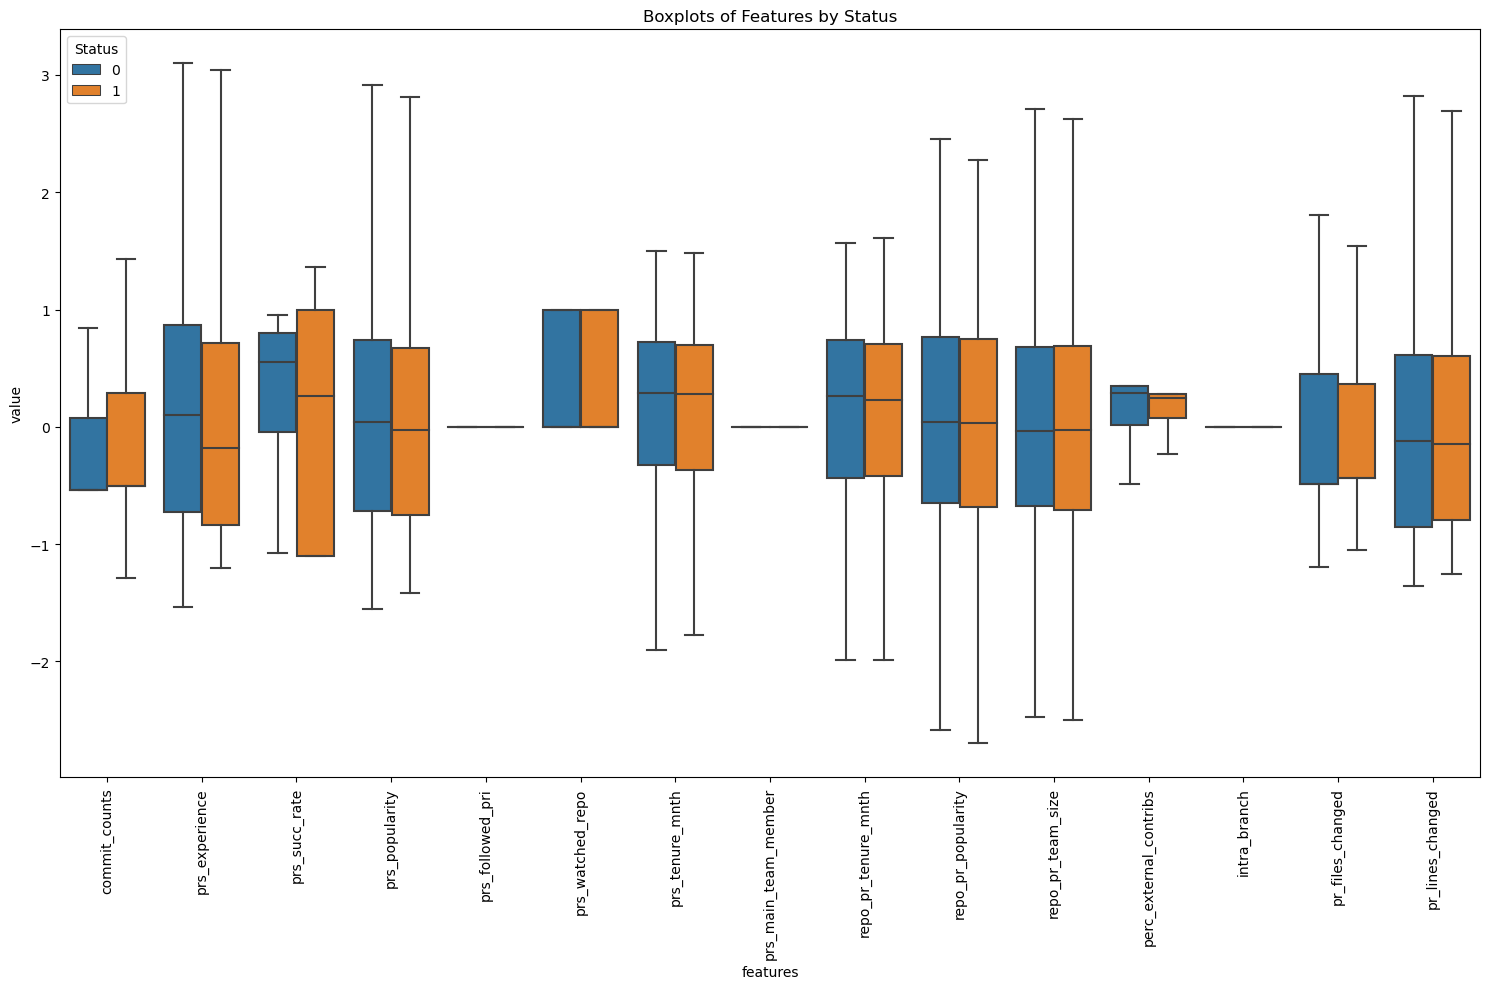

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and 'status' is the column with binary status
# and df contains all the necessary columns already

# List of features to plot (excluding non-numeric and target columns)
features_to_plot = ['commit_counts', 'prs_experience', 'prs_succ_rate', 
                    'prs_popularity', 'prs_followed_pri', 'prs_watched_repo', 
                    'prs_tenure_mnth', 'prs_main_team_member', 
                    'repo_pr_tenure_mnth', 'repo_pr_popularity', 'repo_pr_team_size', 
                    'perc_external_contribs', 'intra_branch', 
                    'pr_files_changed', 'pr_lines_changed']

# Melt the DataFrame to long-form for seaborn's boxplot
df_melted = df[features_to_plot + ['status']].melt(id_vars='status', var_name='features', value_name='value')

# Initialize the figure size
plt.figure(figsize=(15, 10))

# Create the boxplot
sns.boxplot(x='features', y='value', hue='status', data=df_melted, showfliers=False)

# Improve aesthetics of the plot
plt.xticks(rotation=90)  # Rotate the x labels to prevent overlap
plt.title('Boxplots of Features by Status')
plt.legend(title='Status')

# Show the plot
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlap
plt.show()


## Stage 1

In [57]:
X = df.drop(['status', 'manual_analysis','pr_id','repo_id'], axis=1)
Y = df['status']

consistently_correct = pd.Series(True, index=df.index)


# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

all_accuracies = []
for train_index, test_index in skf.split(X, Y):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    model_stage1 = xgb.XGBClassifier()

    model_stage1.fit(x_train, y_train)
    y_pred = model_stage1.predict(x_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    all_accuracies.append(report)
    consistently_correct[test_index] &= (y_pred == y_test)

#this is for the next stage
consistently_correct_df = df[consistently_correct]


metrics_df = pd.DataFrame(all_accuracies)





In [59]:
y_for_next_stage = consistently_correct_df['status']


In [70]:
#number of duplicated rows in the consistently_correct_df
consistently_correct_df.duplicated().sum()


0

In [79]:
#show the rows where consistently_correct is True
consistently_correct_df[consistently_correct_df['Consistently_Correct'] == False]


,pr_id,commit_counts,prs_experience,prs_succ_rate,prs_popularity,prs_followed_pri,prs_watched_repo,prs_tenure_mnth,prs_main_team_member,repo_pr_tenure_mnth,repo_pr_popularity,repo_pr_team_size,perc_external_contribs,intra_branch,pr_files_changed,pr_lines_changed,repo_id,status,manual_analysis,Consistently_Correct
0,2697422,-0.500975,1.915057,1.150350,-0.444593,0,0,0.077583,0,0.224940,1.028133,0.992756,-0.699726,0,-1.047192,-1.251865,6,1,3,False
1,7456135,-0.500975,2.676846,0.764089,-0.161012,0,0,0.488885,0,0.608178,1.292924,1.375811,-0.232106,0,-1.047192,-1.251865,6,1,3,False
2,645270,-0.500975,0.995788,1.083482,0.968358,0,1,-1.253013,0,-0.069841,1.172173,0.886383,0.179764,0,-1.047192,-1.251865,183,1,3,False
3,2203867,-0.500975,1.759672,0.880055,1.906032,1,1,0.279995,0,0.280881,1.227766,1.307105,0.144283,0,-1.047192,-1.251865,183,1,4,False
4,23622497,-0.500975,0.105514,-1.103914,-0.997446,1,1,-1.017751,0,1.009221,1.516362,1.220494,-0.886764,0,-1.047192,-1.251865,340,1,10,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52773,10206184,1.891739,-1.184537,-1.714328,-1.135762,0,1,-0.639497,0,0.024575,-0.285306,-0.341358,0.351508,0,1.862131,2.420041,3169142,0,12,False
52774,17424139,-0.540434,-1.532904,-1.714328,-1.555667,0,0,-2.424759,0,0.345082,-0.023060,0.051210,0.351508,0,-0.074221,0.321650,3169142,0,12,False
52775,42683640,-0.540434,-0.428608,0.790595,-0.890133,0,0,0.043169,0,0.793290,0.323049,0.395071,0.351508,0,1.340741,1.469206,3169142,0,12,False
52776,3174234,-1.587914,-1.184537,-1.714328,0.288689,1,0,0.708682,0,-0.120274,-2.262391,-1.822777,NaN,0,-1.195553,-1.357043,7415938,0,12,False


In [67]:
y_for_next_stage.count()
#52723 compared to 52778. looks correct based on our accuracy 55 are gone

52723

### Not looked at for now

In [28]:
model_stage1 = xgb.XGBClassifier()
model_stage1.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [29]:
predictions_stage1 = model_stage1.predict(x_test)
print("Stage 1 - Classification Report:\n", classification_report(y_test, predictions_stage1))


Stage 1 - Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8565
           1       1.00      0.99      1.00      2000

    accuracy                           1.00     10565
   macro avg       1.00      1.00      1.00     10565
weighted avg       1.00      1.00      1.00     10565



In [80]:
full_predictions_stage1 = model_stage1.predict(df.drop(['status', 'manual_analysis', 'pr_id','repo_id'], axis=1))
# Adding predictions back to the dataset
df['predicted_status'] = full_predictions_stage1


In [81]:
df.head(10003)
#show how many instances are predicted_status and status are different
df[df['predicted_status'] != df['status']]

,pr_id,commit_counts,prs_experience,prs_succ_rate,prs_popularity,prs_followed_pri,prs_watched_repo,prs_tenure_mnth,prs_main_team_member,repo_pr_tenure_mnth,repo_pr_popularity,repo_pr_team_size,perc_external_contribs,intra_branch,pr_files_changed,pr_lines_changed,repo_id,status,manual_analysis,predicted_status
385,10710116,2.052480,0.551998,0.377336,-1.415663,0,0,-1.253013,0,0.545840,0.136861,-0.148184,0.035603,1,1.705726,2.109971,9204,1,3,0
902,4109359,1.926326,0.551998,0.730687,0.449347,0,1,0.077583,1,-2.544086,-1.556927,-1.032777,-0.935148,0,3.212820,2.061389,9281863,1,11,0
1034,41500541,2.363751,-0.473401,0.780038,0.968358,0,0,0.587516,0,0.647841,0.815280,0.585820,0.214885,0,6.285401,2.338621,6401040,1,0,0
1100,6390465,2.317450,0.257108,0.305998,1.228275,0,1,0.354925,0,-0.864063,-1.345569,-0.758361,0.179764,0,0.881939,1.108024,7176443,1,10,0
1490,9041941,2.052480,0.400404,0.522617,-0.089947,0,0,0.742459,0,-0.589978,-1.596947,-0.990372,-0.522283,0,2.438667,1.808288,15285703,1,7,0
3265,3817724,2.269178,-0.108146,0.917782,-0.444593,0,0,0.305644,0,-1.127077,-1.151079,-1.243193,-0.192570,0,2.576372,1.891247,8660746,1,8,0
3850,14382193,1.706111,1.118215,0.126238,-0.026376,1,1,0.354925,0,0.686111,-0.433588,-0.499731,-0.076603,0,2.048901,1.119534,62688,1,7,0
4252,19578733,1.531270,1.137150,0.905500,0.083629,0,0,0.967082,0,0.951808,-0.260626,-0.217931,-1.460301,0,1.537983,1.113819,170988,1,10,0
5794,6474200,1.432580,-0.046081,0.636718,0.476167,1,0,-0.181025,0,-0.788819,-1.486026,-1.871830,-4.687270,1,1.537983,1.201711,10982460,1,11,0
6576,16663966,2.408236,1.888922,0.853337,1.220685,1,1,0.928868,0,0.334092,-0.190708,-0.517338,-3.382070,0,2.123141,2.102638,3218707,1,8,0


## Stage 2 with smote

In [81]:
non_merged_data = consistently_correct_df[consistently_correct_df['status'] == 1]
imputer = SimpleImputer(strategy='mean')  
X_non_merged = non_merged_data.drop(['status', 'manual_analysis', 'pr_id','repo_id', 'Consistently_Correct'], axis=1)
X_non_merged_imputed = imputer.fit_transform(X_non_merged)
y_non_merged = non_merged_data['manual_analysis']


In [82]:
non_merged_data.count()

pr_id                     9895
commit_counts             9895
prs_experience            9895
prs_succ_rate             9895
prs_popularity            9895
prs_followed_pri          9895
prs_watched_repo          9895
prs_tenure_mnth           9895
prs_main_team_member      9895
repo_pr_tenure_mnth       9895
repo_pr_popularity        9895
repo_pr_team_size         9895
perc_external_contribs    9665
intra_branch              9895
pr_files_changed          9895
pr_lines_changed          9895
repo_id                   9895
status                    9895
manual_analysis           9895
Consistently_Correct      9895
dtype: int64

In [86]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

classification_reports = []

for train_index, test_index in skf.split(X_non_merged_imputed, y_non_merged):
    x_train_fold, x_test_fold = X_non_merged_imputed[train_index], X_non_merged_imputed[test_index]
    y_train_fold, y_test_fold = y_non_merged.iloc[train_index], y_non_merged.iloc[test_index]

    smote = SMOTE(random_state=42)
    x_train_fold_smote, y_train_fold_smote = smote.fit_resample(x_train_fold, y_train_fold)

    model_non_merged = xgb.XGBClassifier()
    model_non_merged.fit(x_train_fold_smote, y_train_fold_smote)

    y_pred_fold = model_non_merged.predict(x_test_fold)

    report = classification_report(y_test_fold, y_pred_fold, output_dict=True)
    classification_reports.append(report)


/Users/amirrshams/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amirrshams/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amirrshams/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
classification_reports_df = pd.DataFrame(classification_reports)
classification_reports_df


,0,1,2,3,4,5,6,7,8,9,10,11,accuracy,macro avg,weighted avg
0,"{'precision': 0.14285714285714285, 'recall': 0.25, 'f1-score': 0.18181818181818182, 'support': 4}","{'precision': 0.03571428571428571, 'recall': 0.024390243902439025, 'f1-score': 0.028985507246376812, 'support': 41}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12}","{'precision': 0.26666666666666666, 'recall': 0.21505376344086022, 'f1-score': 0.2380952380952381, 'support': 93}","{'precision': 0.03225806451612903, 'recall': 0.0196078431372549, 'f1-score': 0.024390243902439025, 'support': 51}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}","{'precision': 0.1206896551724138, 'recall': 0.10144927536231885, 'f1-score': 0.11023622047244096, 'support': 69}","{'precision': 0.1625, 'recall': 0.13829787234042554, 'f1-score': 0.14942528735632185, 'support': 94}","{'precision': 0.1917808219178082, 'recall': 0.11965811965811966, 'f1-score': 0.14736842105263157, 'support': 117}","{'precision': 0.10526315789473684, 'recall': 0.06666666666666667, 'f1-score': 0.0816326530612245, 'support': 30}","{'precision': 0.39313984168865435, 'recall': 0.5477941176470589, 'f1-score': 0.4577572964669739, 'support': 272}","{'precision': 0.2445414847161572, 'recall': 0.27450980392156865, 'f1-score': 0.2586605080831409, 'support': 204}",0.266667,"{'precision': 0.14128426009533288, 'recall': 0.14645230883972604, 'f1-score': 0.13986412979624743, 'support': 990}","{'precision': 0.23686890152077691, 'recall': 0.26666666666666666, 'f1-score': 0.2463863913871926, 'support': 990}"
1,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4}","{'precision': 0.13043478260869565, 'recall': 0.07317073170731707, 'f1-score': 0.09375, 'support': 41}","{'precision': 0.25, 'recall': 0.16666666666666666, 'f1-score': 0.2, 'support': 12}","{'precision': 0.2698412698412698, 'recall': 0.1827956989247312, 'f1-score': 0.21794871794871795, 'support': 93}","{'precision': 0.10714285714285714, 'recall': 0.058823529411764705, 'f1-score': 0.07594936708860758, 'support': 51}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}","{'precision': 0.175, 'recall': 0.1, 'f1-score': 0.12727272727272726, 'support': 70}","{'precision': 0.18840579710144928, 'recall': 0.13829787234042554, 'f1-score': 0.15950920245398775, 'support': 94}","{'precision': 0.16923076923076924, 'recall': 0.09322033898305085, 'f1-score': 0.12021857923497266, 'support': 118}","{'precision': 0.21052631578947367, 'recall': 0.13333333333333333, 'f1-score': 0.163265306122449, 'support': 30}","{'precision': 0.3793859649122807, 'recall': 0.6360294117647058, 'f1-score': 0.4752747252747253, 'support': 272}","{'precision': 0.27906976744186046, 'recall': 0.2955665024630542, 'f1-score': 0.28708133971291866, 'support': 203}",0.295960,"{'precision': 0.179919793672388, 'recall': 0.1564920071329208, 'f1-score': 0.16002249709242553, 'support': 990}","{'precision': 0.2575723841553228, 'recall': 0.295959595959596, 'f1-score': 0.2635609527276399, 'support': 990}"
2,"{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 41}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12}","{'precision': 0.24561403508771928, 'recall': 0.15217391304347827, 'f1-score': 0.1879194630872483, 'support': 92}","{'precision': 0.1891891891891892, 'recall': 0.1346153846153846, 'f1-score': 0.15730337078651685, 'support': 52}","{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}","{'precision': 0.06666666666666667, 'recall': 0.04285714285714286, 'f1-score': 0.05217391304347826, 'support': 70}","{'precision': 0.18571428571428572, 'recall': 0.13978494623655913, 'f1-score': 0.15950920245398773, 'support': 93}","{'precision': 0.14942528735632185, 'recall': 0.11016949152542373, 'f1-score': 0.12682926829268293, 'support': 118}","{'precision': 0.13333333333333333, 'recall': 0.12903225806451613, 'f1-score': 0.13114754098360656, 'support': 31}","{'precision'

In [89]:
mean_report = classification_reports_df.groupby(classification_reports_df.index).mean()
mean_report

,accuracy
0,0.266667
1,0.295960
2,0.247475
3,0.278788
4,0.266667
5,0.264914
6,0.270981
7,0.283114
8,0.251769
9,0.302326


In [118]:
classification_reports_df_wa = classification_reports_df.drop(columns='accuracy')


averages = {}


for class_label, dicts in classification_reports_df_wa.items():
    metric_sums = {'precision': 0, 'recall': 0, 'f1-score': 0}
    last_support = None
    
    for metric_dict in dicts:
        metric_sums['precision'] += metric_dict['precision']
        metric_sums['recall'] += metric_dict['recall']
        metric_sums['f1_score'] += metric_dict['f1_score']
        last_support = metric_dict['support']
    
    averages[class_label] = {
        'support': last_support,
        'avg_precision': metric_sums['precision'] / len(dicts),
        'avg_recall': metric_sums['recall'] / len(dicts),
        'avg_f1_score': metric_sums['f1_score'] / len(dicts)
    }
averages_df = pd.DataFrame(averages).T

averages_df['avg_precision'] = averages_df['avg_precision'].round(2)
averages_df['avg_recall'] = averages_df['avg_recall'].round(2)
averages_df['avg_f1_score'] = averages_df['avg_f1_score'].round(2)
averages_df['support'] = averages_df['support'].astype(int)


averages_df.reset_index(inplace=True)
averages_df.rename(columns={'index': 'class'}, inplace=True)

averages_df


,class,support,avg_precision,avg_recall,avg_f1-score
0,0,4,0.11,0.05,0.06
1,1,41,0.07,0.05,0.06
2,2,12,0.02,0.02,0.02
3,3,92,0.26,0.20,0.22
4,4,51,0.10,0.06,0.07
5,5,3,0.02,0.03,0.03
6,6,69,0.12,0.08,0.09
7,7,94,0.17,0.14,0.15
8,8,117,0.16,0.11,0.13
9,9,30,0.12,0.10,0.11


### Doing it only once

In [83]:
#imputing for smote, the nan values are only in perc_external_contribs
imputer = SimpleImputer(strategy='mean')  
X_non_merged_imputed = imputer.fit_transform(X_non_merged)

X_train_non_merged, X_test_non_merged, y_train_non_merged, y_test_non_merged = train_test_split(X_non_merged_imputed, y_non_merged, test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_non_merged_smote, y_train_non_merged_smote = smote.fit_resample(X_train_non_merged, y_train_non_merged)



In [84]:
model_non_merged = xgb.XGBClassifier()
model_non_merged.fit(X_train_non_merged_smote, y_train_non_merged_smote)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [85]:
predictions_non_merged = model_non_merged.predict(X_test_non_merged)
print("Stage 2 - Classification Report for Non-merged Data:\n", classification_report(y_test_non_merged, predictions_non_merged))


Stage 2 - Classification Report for Non-merged Data:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.06      0.05      0.05        87
           2       0.06      0.04      0.05        25
           3       0.21      0.20      0.21       166
           4       0.06      0.04      0.05       103
           5       0.00      0.00      0.00         8
           6       0.15      0.06      0.09       155
           7       0.14      0.11      0.12       207
           8       0.17      0.12      0.14       229
           9       0.11      0.10      0.10        62
          10       0.37      0.55      0.44       530
          11       0.24      0.26      0.25       398

    accuracy                           0.25      1979
   macro avg       0.13      0.13      0.12      1979
weighted avg       0.22      0.25      0.23      1979



## Stage 2 without Smote

### without Kfold

In [90]:
X_train_non_merged, X_test_non_merged, y_train_non_merged, y_test_non_merged = train_test_split(X_non_merged, y_non_merged, test_size=0.2, random_state=42)



In [91]:
model_non_merged = xgb.XGBClassifier()
model_non_merged.fit(X_train_non_merged, y_train_non_merged)

# Predictions and evaluation
predictions_non_merged = model_non_merged.predict(X_test_non_merged)
print("Classification Report for Stage 2 - Non-merged Data:\n", classification_report(y_test_non_merged, predictions_non_merged))


Classification Report for Stage 2 - Non-merged Data:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        87
           2       0.00      0.00      0.00        21
           3       0.33      0.18      0.23       181
           4       0.16      0.03      0.05       101
           5       0.00      0.00      0.00         2
           6       0.08      0.02      0.03       146
           7       0.19      0.12      0.15       194
           8       0.19      0.12      0.15       247
           9       0.19      0.05      0.07        65
          10       0.37      0.62      0.46       539
          11       0.25      0.37      0.30       409

    accuracy                           0.29      1997
   macro avg       0.15      0.13      0.12      1997
weighted avg       0.24      0.29      0.25      1997



/Users/amirrshams/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amirrshams/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amirrshams/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Chaotic: 0
Duplicate: 1
Merge Conflict: 2
No Comment: 3
No Reason: 4
Not PR: 5
Quality: 6
Replaced: 7
Resolved: 8
Stale: 9
Successful: 10
Unnecessary: 11


### With kfold

In [ ]:
non_merged_data = consistently_correct_df[consistently_correct_df['status'] == 1]
X_non_merged = non_merged_data.drop(['status', 'manual_analysis', 'pr_id','repo_id', 'Consistently_Correct'], axis=1)
y_non_merged = non_merged_data['manual_analysis']
